In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import operator
from bisect import bisect
%matplotlib inline



In [2]:
class TSP(object):
    def __init__(self,start=1,dissipation=.2,tolerance=.2,alpha=1.0,beta=1.0):
        #inputs
        self.dissipation=dissipation
        self.tolerance=tolerance
        self.alpha=alpha
        self.beta=beta
        self.start=start
        self.step=0
        
        #setup
        self.history_d={} #holds decisions about node order
        self.history_k={}
        self.history_s={}
        self.tsp=self.init_tsp()
        
        #Tracking - last[type][element][node history]
        ##type - p, dist, score, route, dec
        ##element - edge, edge, step, obj, none
        self.last={'p':{},'dist':{},'score':{},'route':{},'dec':{}}
        for e in self.tsp.edges():
            self.last['p'][e]=[]
            self.last['dist'][e]=[]
        for i in xrange(self.tsp.number_of_nodes()-1):
            self.last['route'][i]=[]
        self.last['score'][0]=[]
        self.last['dec'][0]=[] #zero is placeholder
        
        self.d=[self.start]
        self.d_change=[]
        self.history_d[self.step]=list(self.d)
        self.state=self.init_graph(self.tsp)
        self.history_s[self.step]=self.state.copy()
        self.k=self.init_k(self.state)
        #self.last_solution={}
        
        
    
    def init_tsp(self):
        tsp=nx.DiGraph()
        tsp.add_edge(1,2,dist=1.0)
        tsp.add_edge(2,1,dist=1.0)
        tsp.add_edge(1,3,dist=1.0)
        tsp.add_edge(3,1,dist=1.0)        
        tsp.add_edge(1,4,dist=2.0)
        tsp.add_edge(4,1,dist=2.0)
        tsp.add_edge(2,3,dist=3.0)
        tsp.add_edge(3,2,dist=3.0)
        tsp.add_edge(2,4,dist=4.0)
        tsp.add_edge(4,2,dist=4.0)
        tsp.add_edge(3,4,dist=2.0)
        tsp.add_edge(4,3,dist=2.0)
        
        return tsp
        
    def init_graph(self,tsp):
        g=tsp.copy()
        for u,v in g.edges():
            g[u][v]['p']=0.5
            g[u][v]['dist']=0.0

        #print g.edges(data=True)

        return g

    def init_k(self,g):
        k=nx.DiGraph()
        last_visited={}
        
        #k for edge data
        for u,v,d in g.edges(data=True):
            last_visited[(u,v)]={}
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,label=(u,v),p=float(d['p']),step=self.step)
            self.last['p'][(u,v)].append(n_label)
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,label=(u,v),dist=float(d['dist']),step=self.step)
            self.last['dist'][(u,v)].append(n_label)
            
        #k for decision
        n_label=k.number_of_nodes()+1
        k.add_node(n_label,label='decision', d=list(self.d), step=self.step)
        self.last['dec'][0].append(n_label)
        
        self.history_k[self.step]=k.copy()
        self.step+=1

        return k #,last_visited
    
    def walk(self):
        #initialize
        g=self.state.copy()
        tsp=self.tsp.copy()
        tabu=[int(self.start)]

        for i in xrange(g.number_of_nodes()-1):
            #get pheromone list
            n_l=[]
            p_l=[]
            h_l=[]
            dec_point=False #checks if this step is affected by a decision
            for n in g.nodes():
                if n not in tabu:
                    n_l.append(n)
                    
                    if g[tabu[-1]][n]['p']==0.0:
                        dec_point=True
                    p_l.append(g[tabu[-1]][n]['p'])
                    
                    if g[tabu[-1]][n]['dist']==0.0:
                        h_l.append(10.0)
                    else:
                        h_l.append(1.0/g[tabu[-1]][n]['dist'])
                    
            c_l=np.power(p_l,self.alpha)*np.power(h_l,self.beta)
            n_index=self.make_decision(c_l)
            new_n=n_l[n_index]
                
            #update k with edge from tau and dist to edge selection
            n_label=self.k.number_of_nodes()+1
            
            #label is edge number in solution, e is edge added
            self.k.add_node(n_label,label='selection',i=i,e=(tabu[-1],new_n),step=self.step)
            self.last['route'][i].append(n_label)
            
            for e_i in xrange(len(tabu)-1): #iterate through added edges
                #add constraining 
                last=self.last['route'][e_i][-1]
                self.k.add_edge(last,n_label,step=self.step,t=1)
            
            #if influenced by decision, edge from decision not other edge info
            if dec_point:
                #only edge from decision
                self.k.add_edge(self.last['dec'][0][-1],n_label,step=self.step, t=1)
                
            else:
                for n in n_l: #g.nodes():
                    #if n not in tabu: #only non tabu
                    if n != tabu[-1]: #no self-edge
                        e=(tabu[-1],n)
                        if (e[0],e[1]) not in self.tsp.edges(): #self.last_visited.keys():
                            e=(e[1],e[0])

                        self.k.add_edge(self.last['p'][e][-1],n_label,step=self.step, t=2)
                        self.k.add_edge(self.last['dist'][e][-1],n_label,step=self.step, t=2)
                    

                
            #append new node
            tabu.append(new_n)

        score=0.0
        e_r=[tuple(tabu[i:i+2]) for i in xrange(0,len(tabu), 1)]
        del e_r[-1]

        for e in e_r:
            score+=float(tsp[e[0]][e[1]]['dist'])

        return tuple(tabu), score

    def update_edges(self,route,score):
        g_t=self.state.copy()
        g=self.state.copy()
        p=float(self.dissipation)
        tsp=self.tsp.copy()
        
        #print 'before', g_t.edges(data=True)
        #print 'reduction', p
        
        #update k with rout
        #n_label=self.k.number_of_nodes()+1
        #self.k.add_node(n_label,label=route,step=self.step)
        #self.last_solution['route']=n_label
        
        # k edges from tsp edge info to route - now handled in walk
        #for e in self.last_visited:
            #self.k.add_edge(self.last_visited[e]['p'],n_label,step=self.step)
            #self.k.add_edge(self.last_visited[e]['dist'],n_label,step=self.step)
            
        
        e_r=[tuple(route[i:i+2]) for i in xrange(0,len(route), 1)]
        del e_r[-1]
        
        #update distances
        for e in e_r:
            sel_index=e_r.index(e)
            #check ordering
            if (e[0],e[1]) not in self.tsp.edges():
                e=(e[1],e[0])
            
            #update dist in k
            if g_t[e[0]][e[1]]['dist']==0.0:
                dist=float(tsp[e[0]][e[1]]['dist'])
                g_t[e[0]][e[1]]['dist']=dist
                
                #update k for changed distance
                n_label=self.k.number_of_nodes()+1
                last_n=self.last['dist'][(e[0],e[1])][-1]
                self.k.add_node(n_label,label=(e[0],e[1]),dist=float(dist),step=self.step)
                self.k.add_edge(last_n,n_label,step=self.step,t=2)
                self.k.add_edge(self.last['route'][sel_index][-1],n_label,step=self.step,t=1)
                
                self.last['dist'][(e[0],e[1])].append(n_label)
                

        #add k for score
        n_label=self.k.number_of_nodes()+1
        self.k.add_node(n_label,label='score',score=score,step=self.step)
        
        #add k from route selections to score
        for sel,n_list in self.last['route'].iteritems():
                self.k.add_edge(n_list[-1],n_label,step=self.step,t=1)
        
        self.last['score'][0].append(n_label)
        
        t_update=1.0/score
        for u,v,d in g_t.edges(data=True):
            #update pheromone
            g_t[u][v]['p']=float(g[u][v]['p'])*(1.0-p)
            
            #update k for pheromone reduction
            last_n=self.last['p'][(u,v)][-1]
            n_label=self.k.number_of_nodes()+1
            self.k.add_node(n_label,label=(u,v),p=float(d['p']),step=self.step)
            self.k.add_edge(last_n,n_label,step=self.step,t=2)
            self.last['p'][(u,v)].append(n_label)
        
        
        
        for e in e_r:
            sel_index=e_r.index(e)
            #check ordering
            if (e[0],e[1]) not in self.tsp.edges():
                e=(e[1],e[0])
            
            #update k for route score for distance
            last_n=self.last['dist'][(e[0],e[1])][-1]
            self.k.add_edge(last_n,self.last['score'][0][-1],step=self.step,t=1)
                
                
            #update pheromones on included edges    
            g_t[e[0]][e[1]]['p']=float(g_t[e[0]][e[1]]['p'])+t_update*p
            
            #update k for pheromone addition - add edge for walk update
            last_n=self.last['p'][(e[0],e[1])][-1]
            self.k.node[last_n]['p']=float(g_t[e[0]][e[1]]['p'])
            #n_label=self.k.number_of_nodes()+1
            #self.k.add_node(n_label,label=(e[0],e[1]),p=float(g_t[e[0]][e[1]]['p']),step=self.step)
            #self.k.add_edge(last_n,n_label,step=self.step)
            self.k.add_edge(self.last['route'][sel_index][-1],last_n,step=self.step,t=2)
            self.k.add_edge(self.last['score'][0][-1],last_n,step=self.step,t=2)
            #self.last_visited[(e[0],e[1])]['p']=n_label
        
        g_t=self.design(g_t,tolerance=self.tolerance)
        
        self.history_d[self.step]=list(self.d)
        self.history_k[self.step]=self.k.copy()
        self.history_s[self.step]=g_t.copy()
        self.step+=1
        #print 'after', g_t.edges(data=True)    
        return g_t

    def design(self,g,tolerance):
        #makes locks-in step in walk if p(1st node)-p(2nd node)
        #g=self.state.copy()
        g_t=g.copy()
        
        while True:
            if len(self.d)==(g.number_of_nodes()):
                break
            dec_node=self.d[-1]
        
            #Get probabilities
            #get pheromone list
            n_l=[]
            p_l=[]
            h_l=[]
            for n in g.nodes():
                if (n not in self.d):
                    n_l.append(n)
                    p_l.append(g[self.d[-1]][n]['p'])
                    
                    if g[self.d[-1]][n]['dist']==0.0: #only look at edges nodes
                        h_l.append(0.0)
                    else:
                        h_l.append(1.0/g[self.d[-1]][n]['dist'])
                    
            ph_l=np.power(p_l,self.alpha)*np.power(h_l,0.0) #only use pheromone preference
            if sum(ph_l)==0.0:
                perc_l=[1.0/len(ph_l)]*len(ph_l)
            else:
                perc_l=[float(i)/sum(ph_l) for i in ph_l]
            l=list(perc_l)
            #print perc_l
            m_1=l.pop(l.index(max(l)))
            #print l,m_1
            #print m_1-max(l)
            
            if not l: #only one option
                #print 'decision'
                dec_index=perc_l.index(max(perc_l)) #decision index
                node=n_l[dec_index]
                self.d.append(node) #add node to decisions
            
                #Eliminate other edge options
                for n in g.nodes():
                    if n not in self.d:
                        g_t[dec_node][n]['p']=0.0 #now prob of taking that edges is 0
                        
                #update k for decision
                n_label=self.k.number_of_nodes()+1
                self.k.add_node(n_label,label='dec',d=list(self.d),step=self.step)
                self.k.add_edge(self.last['dec'][0][-1],n_label,step=self.step,t=3)
                self.last['dec'][0].append(n_label)
                self.d_change.append(self.step)
                
            elif (m_1-max(l))>=tolerance: #prob gap is larger than tolerance 
                #print 'decision'
                dec_index=perc_l.index(max(perc_l)) #decision index
                node=n_l[dec_index]
                self.d.append(node) #add node to decisions
            
                #Eliminate other edge options
                for n in g.nodes():
                    if n not in self.d:
                        g_t[dec_node][n]['p']=0.0 #now prob of taking that edges is 0
                        
                #update k for decision
                n_label=self.k.number_of_nodes()+1
                self.k.add_node(n_label,label='dec',d=list(self.d),step=self.step)
                self.k.add_edge(self.last['dec'][0][-1],n_label,step=self.step,t=3)
                self.last['dec'][0].append(n_label)
                for n in n_l:
                    e=(dec_node,n)
                    self.k.add_edge(self.last['p'][e][-1],n_label,step=self.step,t=2)
                self.d_change.append(self.step)

                #break
            else:
                break
                
        #self.history_d[self.step]=self.d
            
        return g_t
                
            
        

    def make_decision(self,ph_l):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        if sum(ph_l)==0.0:
            percent_list=[1.0/len(ph_l)]*len(ph_l)
        else:
            percent_list = [float(i)/sum(ph_l) for i in ph_l]   
        cumulative_percent=np.cumsum(percent_list)
        #print cumulative_percent

        #Choose decision index
        select_index=bisect(cumulative_percent,np.random.uniform(0,1,1))

        return select_index




    def k_step(k,t_new,t_old,route,last_visited,changed_d):
        #get step number

        #route
        n_label=k.number_of_nodes()+1
        k.add_node(n_label,r=tuple(route),step=step)

        #changed distance
        for e in changed_d:
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,)

        for e,d in last_visited.iteritems():
            print 'hi'




[4, 3, 1, 2]


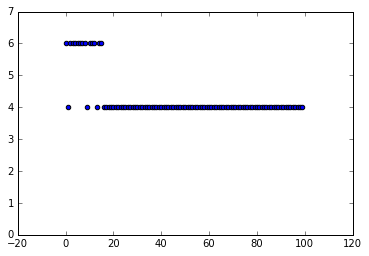

In [3]:
t=TSP(start=4,tolerance=0.5)

routes=[]
for i in xrange(100):
    r,s=t.walk()
    routes.append((r,s))
    t.state=t.update_edges(r,s)
    #if len(t.d)==t.state.number_of_nodes():
        #break
    #print t.edges(data=True)
                  
#print routes
#print t.state.edges(data=True)
print t.d

s=[i[1] for i in routes]
gen=xrange(len(s))
plt.scatter(gen,s)
_=plt.ylim([0.0,max(s)+1.0])

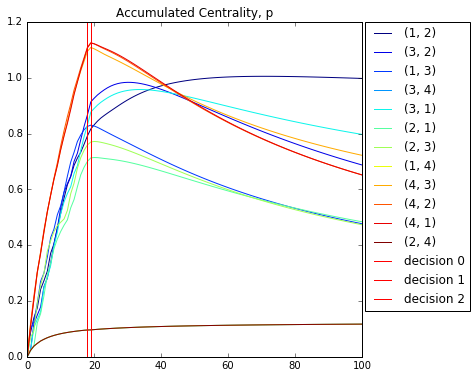

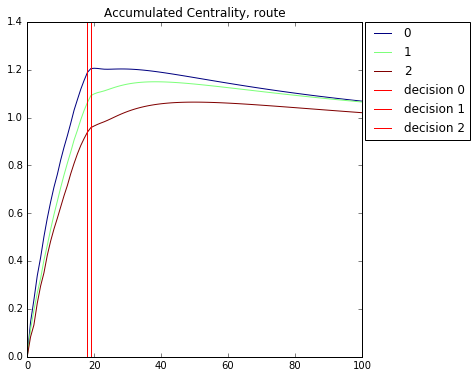

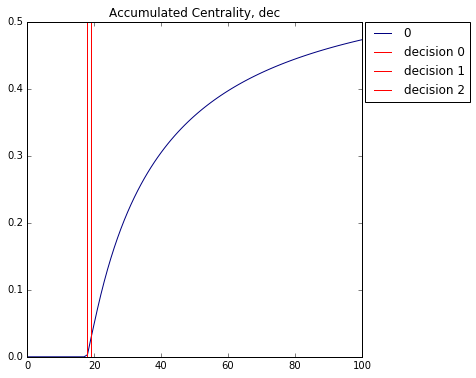

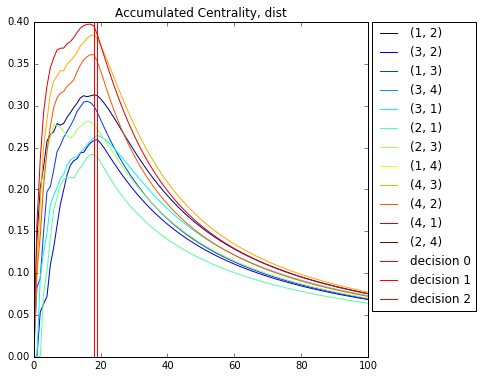

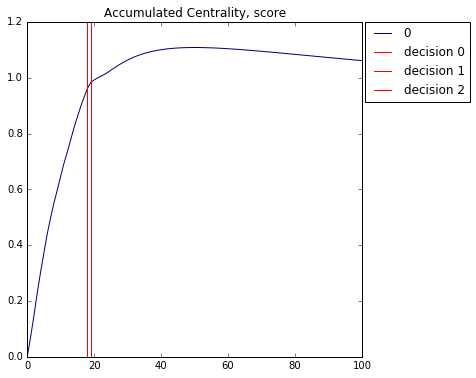

In [6]:
results={}

for s,kd in t.history_k.iteritems():
    c=nx.closeness_centrality(kd,normalized=True)
    #c=nx.betweenness_centrality(kd,normalized=True)
    for k in t.last:
        results.setdefault(k,{})
        for e in t.last[k]:
            n_list=t.last[k][e]
            tc=0.0
            for n in n_list:
                if n in c:
                    tc+=c[n]
                #else:
                    #continue
            
            add=results[k].setdefault(e,[])
            add.append(tc)

#Plotting results
x=range(t.step)
#print x
cmap=cm.get_cmap('jet')
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r', label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('Accumulated Centrality, {}'.format(k))

        
        
#print results

In [53]:
for n, d in t.k.nodes(data=True):
    print n,d

1 {'p': 0.5, 'step': 0, 'label': (1, 2)}
2 {'step': 0, 'dist': 0.0, 'label': (1, 2)}
3 {'p': 0.5, 'step': 0, 'label': (1, 3)}
4 {'step': 0, 'dist': 0.0, 'label': (1, 3)}
5 {'p': 0.5, 'step': 0, 'label': (1, 4)}
6 {'step': 0, 'dist': 0.0, 'label': (1, 4)}
7 {'p': 0.5, 'step': 0, 'label': (2, 1)}
8 {'step': 0, 'dist': 0.0, 'label': (2, 1)}
9 {'p': 0.5, 'step': 0, 'label': (2, 3)}
10 {'step': 0, 'dist': 0.0, 'label': (2, 3)}
11 {'p': 0.5, 'step': 0, 'label': (2, 4)}
12 {'step': 0, 'dist': 0.0, 'label': (2, 4)}
13 {'p': 0.5, 'step': 0, 'label': (3, 1)}
14 {'step': 0, 'dist': 0.0, 'label': (3, 1)}
15 {'p': 0.5, 'step': 0, 'label': (3, 2)}
16 {'step': 0, 'dist': 0.0, 'label': (3, 2)}
17 {'p': 0.5, 'step': 0, 'label': (3, 4)}
18 {'step': 0, 'dist': 0.0, 'label': (3, 4)}
19 {'p': 0.5, 'step': 0, 'label': (4, 1)}
20 {'step': 0, 'dist': 0.0, 'label': (4, 1)}
21 {'p': 0.5, 'step': 0, 'label': (4, 2)}
22 {'step': 0, 'dist': 0.0, 'label': (4, 2)}
23 {'p': 0.5, 'step': 0, 'label': (4, 3)}
24 {'step'

In [59]:
n=32
print n, t.k.node[n]

for u,v, d in t.k.edges(data=True):
    if v==n:
        print (u,v),d
        print t.k.node[u]

32 {'step': 1, 'score': 4.0, 'label': 'score'}
(26, 32) {'step': 1, 't': 1}
{'i': 0, 'step': 1, 'e': (4, 3), 'label': 'selection'}
(27, 32) {'step': 1, 't': 1}
{'i': 1, 'step': 1, 'e': (3, 1), 'label': 'selection'}
(28, 32) {'step': 1, 't': 1}
{'i': 2, 'step': 1, 'e': (1, 2), 'label': 'selection'}
(29, 32) {'step': 1, 't': 1}
{'step': 1, 'dist': 2.0, 'label': (4, 3)}
(30, 32) {'step': 1, 't': 1}
{'step': 1, 'dist': 1.0, 'label': (3, 1)}
(31, 32) {'step': 1, 't': 1}
{'step': 1, 'dist': 1.0, 'label': (1, 2)}


In [26]:
#for u,v, d in t.k.edges(data=True):
    #print (u,v),d

In [22]:
for u,v, d in t.k.edges(data=True):
    if v==28:
        print (u,v),d

(7, 28) {'step': 1, 't': 2}
(8, 28) {'step': 1, 't': 2}
(26, 28) {'step': 1, 't': 1}
(27, 28) {'step': 1, 't': 1}


In [38]:
t.last['dec']

[25, 355, 356, 357]

In [82]:
bc=nx.betweenness_centrality(t.k)
m_key=max(bc.iteritems(), key=operator.itemgetter(1))[0]
print m_key
print bc[m_key]
print t.k.node[m_key]

83
0.0262039628562
{'i': 1, 'step': 4, 'e': (3, 2), 'label': 'selection'}


In [83]:
kc=nx.katz_centrality(t.k)
m_key=max(kc.iteritems(), key=operator.itemgetter(1))[0]
print m_key

print kc[m_key]
print t.k.node[m_key]

214
0.0942701237294
{'step': 12, 'score': 6.0, 'label': 'score'}


In [113]:
cc=nx.closeness_centrality(t.k)
m_key=max(cc.iteritems(), key=operator.itemgetter(1))[0]
print m_key

print cc[m_key]
print t.k.node[m_key]

67
0.0894700889158
{'step': 3, 'dist': 2.0, 'label': (4, 1)}


In [75]:
print t.last['dist'][(4,3)]

[24, 48]


In [76]:
print t.last['dec']

[25, 371, 372, 373]


In [114]:
c=nx.closeness_centrality(t.k)

results={}

for k in t.last:
    results[k]={}
    for e in t.last[k]:
        n_list=t.last[k][e]
        tc=0.0
        for n in n_list:
            tc+=c[n]           

        results[k][e]=tc
print results

{'p': {(1, 2): 1.0373130316710977, (3, 2): 0.6895461523079889, (1, 3): 1.049643841872574, (3, 4): 0.11119901152759167, (3, 1): 0.6316839081403003, (2, 1): 0.44203179101481965, (2, 3): 0.8947354006969268, (1, 4): 0.11119901152759167, (4, 3): 1.0631854908437868, (4, 2): 1.0895181043585642, (4, 1): 1.039289551016188, (2, 4): 0.11119901152759167}, 'route': {0: 1.1638752606711635, 1: 1.1629274138595571, 2: 1.0535721909745612}, 'dec': {0: 0.20688650854871016}, 'dist': {(1, 2): 0.1574456924850825, (3, 2): 0.14477010422113543, (1, 3): 0.1503719072030119, (3, 4): 0.0, (3, 1): 0.1353444490999247, (2, 1): 0.13729100156131596, (2, 3): 0.1491406681270609, (1, 4): 0.0, (4, 3): 0.16740544964215348, (4, 2): 0.16073819244752047, (4, 1): 0.17167144805826476, (2, 4): 0.0}, 'score': {0: 1.11019079798919}}


In [103]:
for k in results:
    for e in results[k]:
        print k,e, results[k][e]

p (1, 2) 0.918557760078
p (3, 2) 1.02277081301
p (1, 3) 0.792585837871
p (3, 4) 0.103464240506
p (3, 1) 0.978637920686
p (2, 1) 0.586330127174
p (2, 3) 0.71273574736
p (1, 4) 0.103464240506
p (4, 3) 1.11326896076
p (4, 2) 1.18353838232
p (4, 1) 1.13819298759
p (2, 4) 0.103464240506
route 0 1.17274821768
route 1 1.11310142433
route 2 0.982067001107
dec 0 0.00792011019284
dist (1, 2) 0.240469557698
dist (3, 2) 0.203881876017
dist (1, 3) 0.216288157766
dist (3, 4) 0.0
dist (3, 1) 0.219800405125
dist (2, 1) 0.200348715855
dist (2, 3) 0.205314752071
dist (1, 4) 0.0
dist (4, 3) 0.269079326097
dist (4, 2) 0.273720041357
dist (4, 1) 0.272165179669
dist (2, 4) 0.0
score 0 1.03401918577


In [121]:
print t.history_k

{0: <networkx.classes.digraph.DiGraph object at 0x000000000EC80DD8>, 1: <networkx.classes.digraph.DiGraph object at 0x000000000EC73BA8>, 2: <networkx.classes.digraph.DiGraph object at 0x000000000A4AD710>, 3: <networkx.classes.digraph.DiGraph object at 0x000000000EC7E470>, 4: <networkx.classes.digraph.DiGraph object at 0x000000000EC7E5C0>, 5: <networkx.classes.digraph.DiGraph object at 0x000000000EC7E1D0>, 6: <networkx.classes.digraph.DiGraph object at 0x000000000E6E6978>, 7: <networkx.classes.digraph.DiGraph object at 0x000000000EC7E898>, 8: <networkx.classes.digraph.DiGraph object at 0x000000000EC7E6D8>, 9: <networkx.classes.digraph.DiGraph object at 0x000000000EC7E358>, 10: <networkx.classes.digraph.DiGraph object at 0x000000000EC7EB70>, 11: <networkx.classes.digraph.DiGraph object at 0x000000000EC7EE80>, 12: <networkx.classes.digraph.DiGraph object at 0x000000000EC7E390>, 13: <networkx.classes.digraph.DiGraph object at 0x000000000EC7EE10>, 14: <networkx.classes.digraph.DiGraph objec

In [166]:
print t.history_d
print t.d_change

{0: [4], 1: [4], 2: [4], 3: [4], 4: [4], 5: [4], 6: [4], 7: [4], 8: [4], 9: [4], 10: [4], 11: [4], 12: [4], 13: [4], 14: [4, 3], 15: [4, 3], 16: [4, 3], 17: [4, 3], 18: [4, 3, 1, 2], 19: [4, 3, 1, 2], 20: [4, 3, 1, 2], 21: [4, 3, 1, 2], 22: [4, 3, 1, 2], 23: [4, 3, 1, 2], 24: [4, 3, 1, 2], 25: [4, 3, 1, 2], 26: [4, 3, 1, 2], 27: [4, 3, 1, 2], 28: [4, 3, 1, 2], 29: [4, 3, 1, 2], 30: [4, 3, 1, 2], 31: [4, 3, 1, 2], 32: [4, 3, 1, 2], 33: [4, 3, 1, 2], 34: [4, 3, 1, 2], 35: [4, 3, 1, 2], 36: [4, 3, 1, 2], 37: [4, 3, 1, 2], 38: [4, 3, 1, 2], 39: [4, 3, 1, 2], 40: [4, 3, 1, 2], 41: [4, 3, 1, 2], 42: [4, 3, 1, 2], 43: [4, 3, 1, 2], 44: [4, 3, 1, 2], 45: [4, 3, 1, 2], 46: [4, 3, 1, 2], 47: [4, 3, 1, 2], 48: [4, 3, 1, 2], 49: [4, 3, 1, 2], 50: [4, 3, 1, 2], 51: [4, 3, 1, 2], 52: [4, 3, 1, 2], 53: [4, 3, 1, 2], 54: [4, 3, 1, 2], 55: [4, 3, 1, 2], 56: [4, 3, 1, 2], 57: [4, 3, 1, 2], 58: [4, 3, 1, 2], 59: [4, 3, 1, 2], 60: [4, 3, 1, 2], 61: [4, 3, 1, 2], 62: [4, 3, 1, 2], 63: [4, 3, 1, 2], 64: [4,

In [170]:
print len(t.last['p'][(1,2)])
for n in t.last['p'][(1,2)]:
    print n, t.k.node[n]
    

 101
1 {'p': 0.5, 'step': 0, 'label': (1, 2)}
33 {'p': 0.4, 'step': 1, 'label': (1, 2)}
52 {'p': 0.37000000000000005, 'step': 2, 'label': (1, 2)}
70 {'p': 0.29600000000000004, 'step': 3, 'label': (1, 2)}
87 {'p': 0.23680000000000004, 'step': 4, 'label': (1, 2)}
103 {'p': 0.18944000000000005, 'step': 5, 'label': (1, 2)}
119 {'p': 0.15155200000000005, 'step': 6, 'label': (1, 2)}
135 {'p': 0.17124160000000005, 'step': 7, 'label': (1, 2)}
151 {'p': 0.13699328000000005, 'step': 8, 'label': (1, 2)}
167 {'p': 0.10959462400000004, 'step': 9, 'label': (1, 2)}
183 {'p': 0.08767569920000004, 'step': 10, 'label': (1, 2)}
199 {'p': 0.12014055936000004, 'step': 11, 'label': (1, 2)}
215 {'p': 0.14611244748800004, 'step': 12, 'label': (1, 2)}
231 {'p': 0.11688995799040003, 'step': 13, 'label': (1, 2)}
247 {'p': 0.14351196639232003, 'step': 14, 'label': (1, 2)}
264 {'p': 0.11480957311385603, 'step': 15, 'label': (1, 2)}
280 {'p': 0.14184765849108483, 'step': 16, 'label': (1, 2)}
296 {'p': 0.16347812679

In [171]:
print len(t.last['p'][(4,3)])
for n in t.last['p'][(4,3)]:
    print n, t.k.node[n]
    

101
23 {'p': 0.5, 'step': 0, 'label': (4, 3)}
44 {'p': 0.4, 'step': 1, 'label': (4, 3)}
63 {'p': 0.37000000000000005, 'step': 2, 'label': (4, 3)}
81 {'p': 0.29600000000000004, 'step': 3, 'label': (4, 3)}
98 {'p': 0.23680000000000004, 'step': 4, 'label': (4, 3)}
114 {'p': 0.18944000000000005, 'step': 5, 'label': (4, 3)}
130 {'p': 0.15155200000000005, 'step': 6, 'label': (4, 3)}
146 {'p': 0.17124160000000005, 'step': 7, 'label': (4, 3)}
162 {'p': 0.17032661333333338, 'step': 8, 'label': (4, 3)}
178 {'p': 0.16959462400000003, 'step': 9, 'label': (4, 3)}
194 {'p': 0.13567569920000003, 'step': 10, 'label': (4, 3)}
210 {'p': 0.15854055936000003, 'step': 11, 'label': (4, 3)}
226 {'p': 0.17683244748800003, 'step': 12, 'label': (4, 3)}
242 {'p': 0.17479929132373337, 'step': 13, 'label': (4, 3)}
258 {'p': 0.1898394330589867, 'step': 14, 'label': (4, 3)}
275 {'p': 0.1852048797805227, 'step': 15, 'label': (4, 3)}
291 {'p': 0.19816390382441817, 'step': 16, 'label': (4, 3)}
307 {'p': 0.2085311230595